In [10]:
#importing all the libraries

import os
import numpy as np
import pandas as pd
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import WeightedRandomSampler

In [11]:
meta = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
unique_lesion_ids = meta['lesion_id'].unique()

train_ids, temp_ids = train_test_split(unique_lesion_ids, test_size=0.3)
test_ids, validation_ids = train_test_split(temp_ids, test_size=0.5)

train_meta = meta[meta['lesion_id'].isin(train_ids)]
test_meta = meta[meta['lesion_id'].isin(test_ids)]
validation_meta = meta[meta['lesion_id'].isin(validation_ids)]

print(f"train ({100 * len(train_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{train_meta.head()}\n")
print(f"test ({100 * len(test_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{test_meta.head()}\n")
print(f"validation ({100 * len(validation_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{validation_meta.head()}\n")


train (70.61407888167749%):
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

test (14.757863205192212%):
      lesion_id      image_id   dx dx_type   age     sex     localization
11  HAM_0004234  ISIC_0029396  bkl   histo  85.0  female            chest
12  HAM_0004234  ISIC_0025984  bkl   histo  85.0  female            chest
18  HAM_0007571  ISIC_0029836  bkl   histo  70.0    male            chest
19  HAM_0007571  ISIC_0032129  bkl   histo  70.0    male            chest
25  HAM_0002521  ISIC_0027828  bkl   histo  40.0    male  upper extremity

validation (14.628057913130304%):
      lesion_id      image_id   dx dx_type   age     sex     l

In [12]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, dir_part1, dir_part2, transform = None):
        self.annotation = dataframe
        self.dir_part1 = dir_part1
        self.dir_part2 = dir_part2
        self.transform = transform
        self.label_map = {
             'akiec': 0, 
             'bcc': 1, 
             'bkl': 2, 
             'df': 3, 
             'mel': 4, 
             'nv': 5, 
             'vasc': 6}

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):
        img_id = self.annotation.iloc[index]['image_id']#ImageID on column 2

        path_part1 = os.path.join(self.dir_part1, img_id + '.jpg')
        path_part2 = os.path.join(self.dir_part2, img_id + '.jpg')
        if os.path.exists(path_part1):
            img_name = path_part1
        elif os.path.exists(path_part2):
            img_name = path_part2
        else:
            raise FileNotFoundError(f"Image {img_id} not found in part1 or part2")
            
        image = Image.open(img_name).convert('RGB')
        
        label_text = self.annotation.iloc[index]['dx']
        y_label = torch.tensor(self.label_map[label_text])

        if self.transform:
            image = self.transform(image)

        return image, y_label



In [13]:
from torchvision import transforms

# Training transforms (Randomness added)
train_transforms = transforms.Compose([
    transforms.Resize((96, 96)),       
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),    
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize(                # Standardizes to ImageNet distribution
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transforms (No Randomness, just resizing)
val_transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
def get_device():
    if torch.cuda.is_available():
        print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    
    elif torch.backends.mps.is_available():
        print("✅ Apple Silicon GPU Detected")
        return torch.device("mps")
    
    else:
        print("⚠️ No GPU detected. Training will be slow.")
        return torch.device("cpu")


device = get_device()

✅ GPU Detected: Tesla P100-PCIE-16GB


In [15]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x
        

class SkinCancerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        #feature extraction
        self.block1 = DoubleConvBlock(3, 32)
        self.block2 = DoubleConvBlock(32, 64)
        self.block3 = DoubleConvBlock(64, 128)
        self.block4 = DoubleConvBlock(128, 256)
        
        self.flatten_size = 256 * 6 * 6
        
        # First fully connected layer
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.2)
        # Second fully connected layer 
        self.fc2 = nn.Linear(512, 128)
        
        #third fully connected layer that outputs our 10 labels
        self.fc3 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        #flatten the data
        x = x.view(-1, self.flatten_size)
        #FC layers
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

skinCancerCNN = SkinCancerCNN()
print(skinCancerCNN)

SkinCancerCNN(
  (block1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): DoubleConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_s

In [16]:
criterion = nn.CrossEntropyLoss(weight=None)

In [17]:
learning_rate = 0.0008

optimizer = optim.Adam(skinCancerCNN.parameters(), learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [18]:
# Define your paths (Adjust these to match your specific Kaggle input structure)
dir_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
dir_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Create Datasets passing BOTH directories
train_dataset = SkinCancerDataset(train_meta, dir_1, dir_2, transform=train_transforms)
val_dataset = SkinCancerDataset(validation_meta, dir_1, dir_2, transform=val_transforms)
test_dataset = SkinCancerDataset(test_meta, dir_1, dir_2, transform=val_transforms)

label_map = {
    'akiec': 0,
    'bcc' : 1,
    'bkl' : 2,
    'df' : 3,
    'mel' : 4,
    'nv' : 5,
    'vasc' : 6,
}

#create sampler weights
labels, counts = np.unique(meta['dx'], return_counts=True)
weights = 1.0 / np.sqrt(counts) 
weights = weights / weights.sum() * len(counts)

print(labels, label_map)

sample_weights = [weights[label_map[label]] for label in train_meta['dx']]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           sampler=sampler)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc'] {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


🚀 Starting training on cuda with Early Stopping...


Epoch [1/60]  Train Loss: 1.5096 | Val Loss: 1.0021 | Val Acc: 62.39%
   ✅ Validation Loss Improved. Model Saved.


Epoch [2/60]  Train Loss: 1.3234 | Val Loss: 0.9372 | Val Acc: 62.12%
   ✅ Validation Loss Improved. Model Saved.


Epoch [3/60]  Train Loss: 1.2481 | Val Loss: 0.8701 | Val Acc: 66.89%
   ✅ Validation Loss Improved. Model Saved.


Epoch [4/60]  Train Loss: 1.2014 | Val Loss: 0.8753 | Val Acc: 67.58%
   ⚠️ No improvement for 1/10 epochs.


Epoch [5/60]  Train Loss: 1.1884 | Val Loss: 0.9104 | Val Acc: 63.96%
   ⚠️ No improvement for 2/10 epochs.


Epoch [6/60]  Train Loss: 1.1498 | Val Loss: 0.8531 | Val Acc: 68.33%
   ✅ Validation Loss Improved. Model Saved.


Epoch [7/60]  Train Loss: 1.1323 | Val Loss: 0.8485 | Val Acc: 65.94%
   ✅ Validation Loss Improved. Model Saved.


Epoch [8/60]  Train Loss: 1.1005 | Val Loss: 0.8020 | Val Acc: 68.46%
   ✅ Validation Loss Improved. Model Saved.


Epoch [9/60]  Train Loss: 1.1140 | Val Loss: 0.8813 | Val Acc: 63.21%
   ⚠️ No improvement for 1/10 epochs.


Epoch [10/60]  Train Loss: 1.0554 | Val Loss: 0.7735 | Val Acc: 70.51%
   ✅ Validation Loss Improved. Model Saved.


Epoch [11/60]  Train Loss: 1.0415 | Val Loss: 0.7490 | Val Acc: 70.03%
   ✅ Validation Loss Improved. Model Saved.


Epoch [12/60]  Train Loss: 1.0378 | Val Loss: 0.7396 | Val Acc: 72.76%
   ✅ Validation Loss Improved. Model Saved.


Epoch [13/60]  Train Loss: 1.0065 | Val Loss: 0.7660 | Val Acc: 72.01%
   ⚠️ No improvement for 1/10 epochs.


Epoch [14/60]  Train Loss: 0.9822 | Val Loss: 0.7353 | Val Acc: 72.97%
   ✅ Validation Loss Improved. Model Saved.


Epoch [15/60]  Train Loss: 0.9915 | Val Loss: 0.7642 | Val Acc: 68.94%
   ⚠️ No improvement for 1/10 epochs.


Epoch [16/60]  Train Loss: 0.9674 | Val Loss: 0.7236 | Val Acc: 72.90%
   ✅ Validation Loss Improved. Model Saved.


Epoch [17/60]  Train Loss: 0.9456 | Val Loss: 0.7185 | Val Acc: 73.45%
   ✅ Validation Loss Improved. Model Saved.


Epoch [18/60]  Train Loss: 0.9246 | Val Loss: 0.7300 | Val Acc: 72.49%
   ⚠️ No improvement for 1/10 epochs.


Epoch [19/60]  Train Loss: 0.9156 | Val Loss: 0.7282 | Val Acc: 72.63%
   ⚠️ No improvement for 2/10 epochs.


Epoch [20/60]  Train Loss: 0.9107 | Val Loss: 0.6758 | Val Acc: 75.49%
   ✅ Validation Loss Improved. Model Saved.


Epoch [21/60]  Train Loss: 0.8875 | Val Loss: 0.6452 | Val Acc: 77.27%
   ✅ Validation Loss Improved. Model Saved.


Epoch [22/60]  Train Loss: 0.8754 | Val Loss: 0.6707 | Val Acc: 74.20%
   ⚠️ No improvement for 1/10 epochs.


Epoch [23/60]  Train Loss: 0.8564 | Val Loss: 0.7002 | Val Acc: 74.20%
   ⚠️ No improvement for 2/10 epochs.


Epoch [24/60]  Train Loss: 0.8510 | Val Loss: 0.7051 | Val Acc: 73.17%
   ⚠️ No improvement for 3/10 epochs.


Epoch [25/60]  Train Loss: 0.8521 | Val Loss: 0.7004 | Val Acc: 70.03%
   ⚠️ No improvement for 4/10 epochs.


Epoch [26/60]  Train Loss: 0.8228 | Val Loss: 0.6585 | Val Acc: 74.40%
   ⚠️ No improvement for 5/10 epochs.


Epoch [27/60]  Train Loss: 0.8016 | Val Loss: 0.6712 | Val Acc: 75.36%
   ⚠️ No improvement for 6/10 epochs.


Epoch [28/60]  Train Loss: 0.8180 | Val Loss: 0.7054 | Val Acc: 74.47%
   ⚠️ No improvement for 7/10 epochs.


Epoch [29/60]  Train Loss: 0.8209 | Val Loss: 0.6354 | Val Acc: 76.25%
   ✅ Validation Loss Improved. Model Saved.


Epoch [30/60]  Train Loss: 0.7954 | Val Loss: 0.6844 | Val Acc: 76.38%
   ⚠️ No improvement for 1/10 epochs.


Epoch [31/60]  Train Loss: 0.7786 | Val Loss: 0.6962 | Val Acc: 72.08%
   ⚠️ No improvement for 2/10 epochs.


Epoch [32/60]  Train Loss: 0.7983 | Val Loss: 0.6773 | Val Acc: 73.72%
   ⚠️ No improvement for 3/10 epochs.


Epoch [33/60]  Train Loss: 0.7767 | Val Loss: 0.6490 | Val Acc: 75.63%
   ⚠️ No improvement for 4/10 epochs.


Epoch [34/60]  Train Loss: 0.7649 | Val Loss: 0.6289 | Val Acc: 77.13%
   ✅ Validation Loss Improved. Model Saved.


Epoch [35/60]  Train Loss: 0.7599 | Val Loss: 0.6238 | Val Acc: 78.09%
   ✅ Validation Loss Improved. Model Saved.


Epoch [36/60]  Train Loss: 0.7438 | Val Loss: 0.6457 | Val Acc: 76.52%
   ⚠️ No improvement for 1/10 epochs.


Epoch [37/60]  Train Loss: 0.7289 | Val Loss: 0.6471 | Val Acc: 77.00%
   ⚠️ No improvement for 2/10 epochs.


Epoch [38/60]  Train Loss: 0.7159 | Val Loss: 0.7201 | Val Acc: 72.63%
   ⚠️ No improvement for 3/10 epochs.


Epoch [39/60]  Train Loss: 0.7211 | Val Loss: 0.7257 | Val Acc: 71.54%
   ⚠️ No improvement for 4/10 epochs.


Epoch [40/60]  Train Loss: 0.6883 | Val Loss: 0.7590 | Val Acc: 71.19%
   ⚠️ No improvement for 5/10 epochs.


Epoch [41/60]  Train Loss: 0.7218 | Val Loss: 0.6392 | Val Acc: 76.79%
   ⚠️ No improvement for 6/10 epochs.


Epoch [42/60]  Train Loss: 0.6963 | Val Loss: 0.6602 | Val Acc: 75.84%
   ⚠️ No improvement for 7/10 epochs.


Epoch [43/60]  Train Loss: 0.6980 | Val Loss: 0.6450 | Val Acc: 74.81%
   ⚠️ No improvement for 8/10 epochs.


Epoch [44/60]  Train Loss: 0.6825 | Val Loss: 0.7549 | Val Acc: 71.54%
   ⚠️ No improvement for 9/10 epochs.


Epoch [45/60]  Train Loss: 0.6772 | Val Loss: 0.6587 | Val Acc: 76.25%
   ⚠️ No improvement for 10/10 epochs.

🛑 Early Stopping Triggered! Training stopped at Epoch 45.
Training Finished.


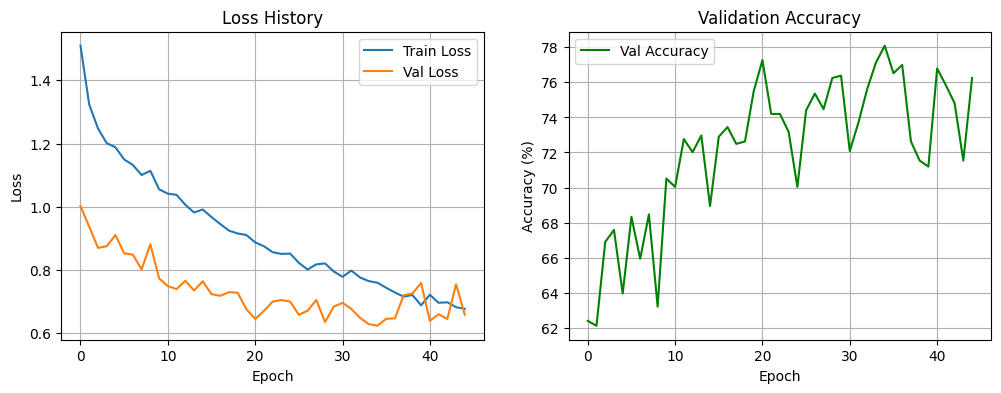

In [19]:
import time
from tqdm import tqdm # Library for progress bars
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
patience = 10        # How many epochs to wait before stopping if no improvement
min_delta = 0.0005   # Minimum change to qualify as an improvement
early_stop_counter = 0
best_val_loss = float('inf')
num_epochs = 60

# Move model to device
model = skinCancerCNN.to(device)

# History storage
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f"🚀 Starting training on {device} with Early Stopping...")

# ==========================================
# TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    
    # --- 1. Training Phase ---
    model.train()
    running_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    # 'desc' sets the text before the bar
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_loss)

    # --- 2. Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_acc = 100 * correct / total
    
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_acc)

    # Print Clean Stats
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_acc:.2f}%")

    # ==========================================
    # EARLY STOPPING LOGIC
    # ==========================================
    # Check if this validation loss is the best we've seen
    if epoch_val_loss < (best_val_loss - min_delta):
        best_val_loss = epoch_val_loss
        early_stop_counter = 0 # Reset counter
        torch.save(model.state_dict(), 'best_skin_cancer_model.pth')
        print(f"   ✅ Validation Loss Improved. Model Saved.")
    else:
        early_stop_counter += 1
        print(f"   ⚠️ No improvement for {early_stop_counter}/{patience} epochs.")
        
    if early_stop_counter >= patience:
        print(f"\n🛑 Early Stopping Triggered! Training stopped at Epoch {epoch+1}.")
        break

print("Training Finished.")

# ==========================================
# VISUALIZATION
# ==========================================
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['val_acc'], label='Val Accuracy', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Run the plot
plot_training_history(history)      
       

✅ Successfully loaded the best saved model.
🔄 Processing validation set for Confusion Matrix...
✅ Predictions complete.


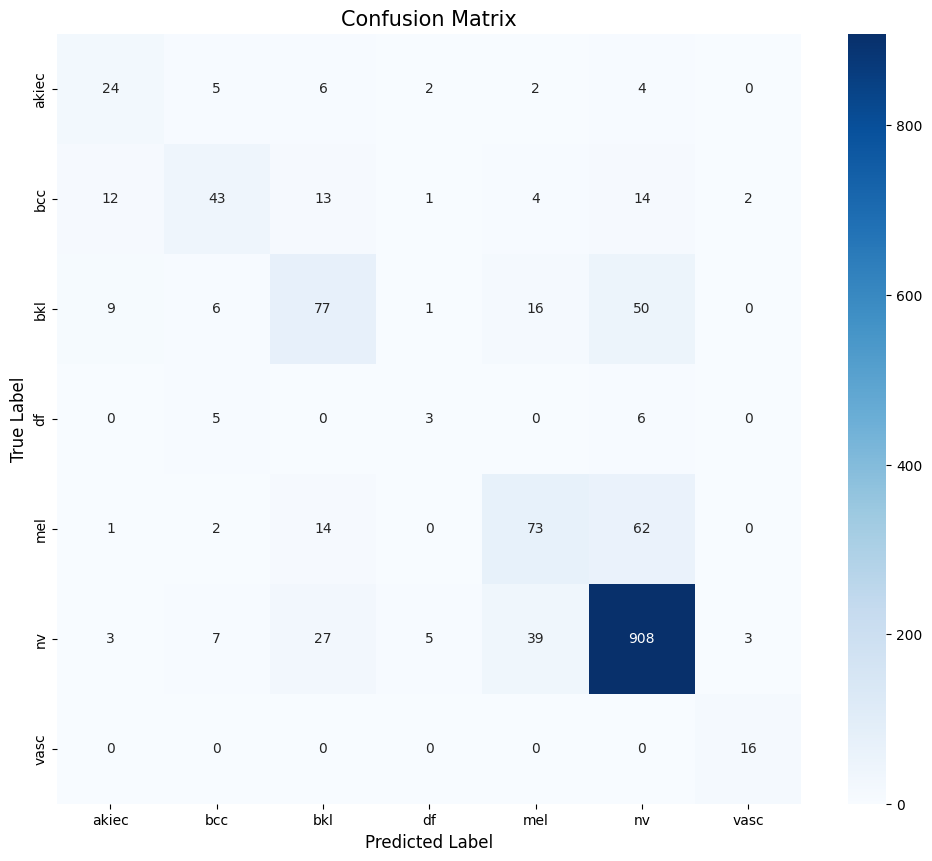


📋 Classification Report:

              precision    recall  f1-score   support

       akiec       0.49      0.56      0.52        43
         bcc       0.63      0.48      0.55        89
         bkl       0.56      0.48      0.52       159
          df       0.25      0.21      0.23        14
         mel       0.54      0.48      0.51       152
          nv       0.87      0.92      0.89       992
        vasc       0.76      1.00      0.86        16

    accuracy                           0.78      1465
   macro avg       0.59      0.59      0.58      1465
weighted avg       0.77      0.78      0.77      1465



In [20]:
 # Confusion Matrix
model = skinCancerCNN.to(device)
y_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Load the weights from the file saved during training
# (This requires 'best_skin_cancer_model.pth' to exist in your current folder)
try:
    model.load_state_dict(torch.load('best_skin_cancer_model.pth'))
    print("✅ Successfully loaded the best saved model.")
except FileNotFoundError:
    print("⚠️ File not found. Using current model weights instead.")

model.eval() # Set to evaluation mode (Turns off Dropout)

# 2. PREDICTION LOOP: Get all predictions for the validation set
y_true = []
y_pred = []

print("🔄 Processing validation set for Confusion Matrix...")

with torch.no_grad(): # Save memory, we don't need gradients here
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Move back to CPU and convert to numpy for Sklearn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("✅ Predictions complete.")

# 3. COMPUTE & PLOT: Create the Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

# 4. REPORT: Print Precision, Recall, and F1-Score
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=y_labels))